In [1]:
# 기본
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps, edge_adj_mat
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED, STGAT
from models.STGCN_with_auxiliary_network_model import STGCNWithAux
from models.STLinear import STLinear
from models.STLinear_deriven import STLinear_HopBiased, STLinear_SPE, compute_spe_torch


c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


In [2]:
# MAPE
class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


In [3]:
# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 64
EPOCHS = 50
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# seed=42
# torch.manual_seed(seed)
# np.random.seed(seed)
# if torch.cuda.is_available():
#     # 현재 GPU에 대한 시드 고정
#     torch.cuda.manual_seed(seed)
#     # 다중 GPU 환경에서도 모두 같은 시드 고정
#     torch.cuda.manual_seed_all(seed)

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

aux_data = np.load('dataset/traffic_dataset_13_aux_smoothen.npy') # (T_aux_total, E, C) (10080, 50, 3)
aux_tensor = torch.from_numpy(aux_data).float().to(DEVICE)

# 2) SPE 텐서 계산 (NumPy 인접행렬 → SPE)
spe_dim = 32
spe_tensor = compute_spe_torch(edge_adj_mat, spe_dim, normalized=True)  # (E, p)
spe_tensor = spe_tensor.to(DEVICE)

In [4]:
# 공통 파라미터 및 모델 목록 정의

DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
WINDOW       = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS     = [2]                  # 시각화할 edge index 리스트
T_TOTAL      = data.shape[0]        # 전체 타임스텝 수
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

models = {
#    "GCNMLP":    GCNMLP,
#    "DCRNN":     DCRNN,
#    "STGCN":     STGCN,
#    "MLPBASED":  MLPBASED,
#    "STGAT": STGAT,
#    "STGCNWithAux": STGCNWithAux,
#    "STLinear_h1": STLinear,
#    "STLinear": STLinear
#    "STLinear_HopBiased": STLinear_HopBiased,
    "STLinear_SPE": STLinear_SPE
}

In [5]:
# Training

for name, ModelClass in models.items():
    print(f"\n=== Training {name} ===")
    # (1) 배치 데이터에서 차원 정보 추출
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    # (2) 모델 인스턴스화
    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        # GCNMLP, DCRNN, STGCN 공통 생성자 인자
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=32, encoder_depth=1,
            dropout=0.1
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
        elif name == "STGAT":
            kwargs.update(encoder_depth=2, kernel_size=3, heads=4)
        elif name == "STGCNWithAux":
            kwargs = dict(
                    num_nodes=E,
                    node_feature_dim=5,
                    pred_node_dim=3,
                    encoder_embed_dim=32,
                    aux_embed_dim=32,
                    aux_data=aux_tensor,
            )
        elif name == "STLinear_h1":
            kwargs = dict(num_nodes=50,
                    kernel_size=33,
                    num_layers=6, 
                    num_heads=1,
                    dropout=0.14
            )
        elif name == "STLinear":
            kwargs = dict(num_nodes=50,
                    kernel_size=33,
                    num_layers=6, 
                    num_heads=8,
                    dropout=0.05925151508866461
            )
        elif name == "STLinear_HopBiased":
            kwargs = dict(num_nodes=50,
                    kernel_size=25,
                    input_embedding_dim=32,
                    tod_embedding_dim=32,
                    dow_embedding_dim=32,
                    spatial_embedding_dim=0,
                    adaptive_embedding_dim=0,
                    feed_forward_dim=256,
                    num_heads=4,       # max_hop=3 (즉 1-hop,2-hop,3-hop)
                    num_layers=3,
                    dropout=0.1,
                    use_mixed_proj=True
            )
        elif name == "STLinear_SPE":
            kwargs = dict(num_nodes=edge_adj_mat.shape[0],        # E
                    kernel_size=25,
                    in_steps=12,
                    out_steps=3,
                    steps_per_day=480,
                    input_dim=3,
                    output_dim=3,
                    input_embedding_dim=32,
                    tod_embedding_dim=32,
                    dow_embedding_dim=32,
                    spatial_embedding_dim=0,
                    adaptive_embedding_dim=0,
                    spe_dim=32,                             # SPE 차원
                    feed_forward_dim=256,
                    num_heads=4,
                    num_layers=3,
                    dropout=0.1,
                    use_mixed_proj=True,
                    normalized_laplacian=True,              # 정규화 라플라시안 사용
            )


        model = ModelClass(**kwargs)

    model = model.to(DEVICE)

    # (3) 옵티마이저·손실함수 설정
    weight_decay = 1e-4
    LEARNING_RATE = 1e-4
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
    criterion = torch.nn.L1Loss()

    # (4) Trainer 초기화·학습
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=1,
        device=DEVICE,
        auto_save=True,
        save_dir=SAVE_DIR
    )
    trainer.fit()

    # (5) 가중치 저장
    # save_path = os.path.join(SAVE_DIR, f"{name}.pth")
    # torch.save(model.state_dict(), save_path)
    # print(f"Saved checkpoint: {save_path}")



=== Training STLinear_SPE ===


TypeError: __init__() got an unexpected keyword argument 'model_dim'

이어서 학습하기

In [ ]:
# trainer.get_history()로 얻은 history를 Trainer에 load하면 그래프도 이어서 그려줍니다. 

history = trainer.get_history()

C:\Users\gauoo\AppData\Local\Temp\ipykernel_47980\2577593349.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict   = torch.load("./checkpoints/STLinear_epoch018_

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/STLinear_epoch018_val0.6360.pth'

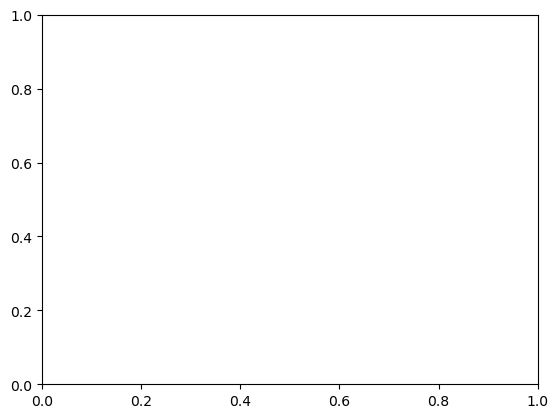

In [ ]:
# 1) Trainer 준비 (epochs=N 은 "추가 학습할 epoch 수")
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
trainer = Trainer(
    model, train_loader, valid_loader,
    optimizer, criterion,
    epochs=5, device=DEVICE,
    auto_save=True, save_dir="./checkpoints",
    early_stopping_patience=5

)

# # 2) 외부에서 미리 로드한 가중치·history가 있으면
# trainer.load_checkpoint(
#     state_dict   = torch.load("./checkpoints/STLinear_epoch018_val0.6360.pth"),
#     history      = history
# )

# 3) 이어서 학습
trainer.fit()


--- Visualizing STLinear_HopBiased ---


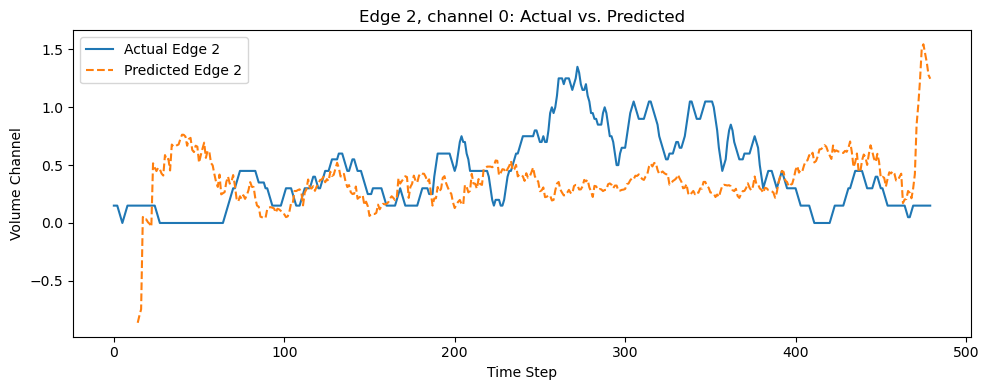

In [ ]:
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
from dataset.dataset_config import week_steps, C_origin
from utils.edge_prediction_visualization import visualize_predictions, add_tod_dow
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)

# ─────────────────────────────────────────────────────────
# 4) 저장된 체크포인트 로드 후 일괄 시각화
# ─────────────────────────────────────────────────────────

for name, ModelClass in models.items():
    # (1) 모델 재생성 (학습 시와 동일한 인자 사용)
    #    -- 이하 2)~3)은 학습 루프와 동일하게 구성합니다.
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=32, encoder_depth=1,
            dropout=0.0
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
        elif name == "STGAT":
            kwargs.update(encoder_depth=2, kernel_size=3, heads=4)
        elif name == "STGCNWithAux":
            kwargs = dict(
                    num_nodes=E,
                    node_feature_dim=5,
                    pred_node_dim=3,
                    encoder_embed_dim=64,
                    aux_embed_dim=64,
                    aux_data=aux_tensor,
                    encoder_depth=3,
            )
        elif name == "STLinear_h1":
            kwargs = dict(num_nodes=50,
                    kernel_size=33,
                    num_layers=6, 
                    num_heads=1,
                    dropout=0.14
            )
        elif name == "STLinear":
            kwargs = dict(num_nodes=50,
                    kernel_size=33,
                    num_layers=6, 
                    num_heads=8,
                    dropout=0.06
            )
        elif name == "STLinear_HopBiased":
            kwargs = dict(num_nodes=50,
                    kernel_size=25,
                    input_embedding_dim=32,
                    tod_embedding_dim=32,
                    dow_embedding_dim=32,
                    spatial_embedding_dim=0,
                    adaptive_embedding_dim=0,
                    feed_forward_dim=256,
                    num_heads=4,       # max_hop=3 (즉 1-hop,2-hop,3-hop)
                    num_layers=3,
                    dropout=0.1,
                    use_mixed_proj=True
            )
        elif name == "STLinear_SPE":
            kwargs = dict(num_nodes=edge_adj_mat.shape[0],        # E
                    kernel_size=25,
                    in_steps=12,
                    out_steps=3,
                    steps_per_day=480,
                    input_dim=3,
                    output_dim=3,
                    input_embedding_dim=32,
                    tod_embedding_dim=32,
                    dow_embedding_dim=32,
                    spatial_embedding_dim=0,
                    adaptive_embedding_dim=0,
                    spe_dim=32,                             # SPE 차원
                    feed_forward_dim=256,
                    num_heads=4,
                    num_layers=3,
                    dropout=0.1,
                    use_mixed_proj=True,
                    normalized_laplacian=True,              # 정규화 라플라시안 사용
            )
        
        model = ModelClass(**kwargs)
        model.to(DEVICE)

    # # (2) 가중치 로드 (임시. 나중에 수정해야 함.)
    # if name == "STGCNWithAux":
    #     ckpt_path = os.path.join(SAVE_DIR, f"STGCNWithAux_epoch033_val0.7441.pth")
    # else:
    #     ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
    # model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE, weights_only=True))
    # model = model.to(DEVICE)

    print(f"\n--- Visualizing {name} ---")
    EDGE_IDS = [2]
    expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
    visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=0)



--- Visualizing STLinear_HopBiased ---


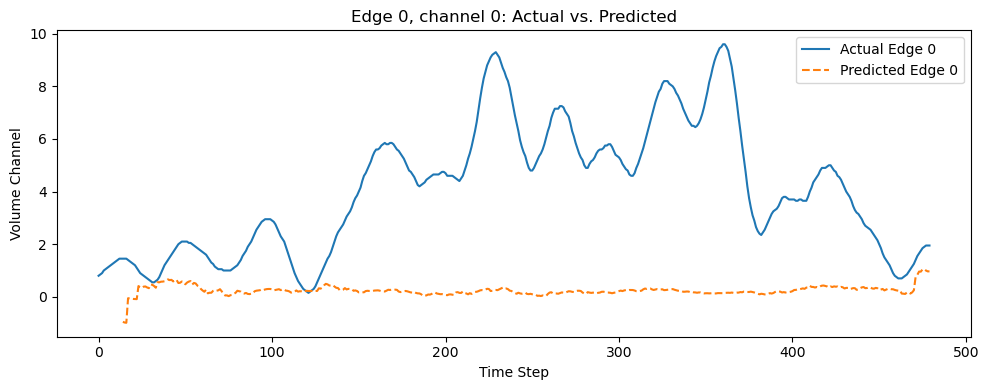

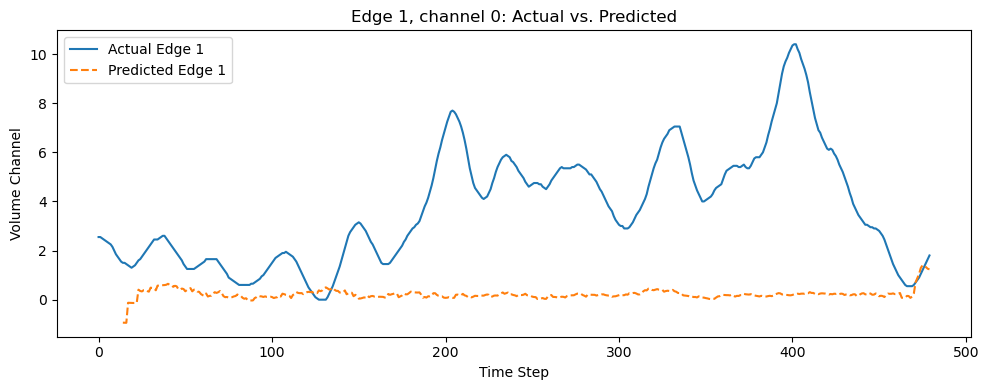

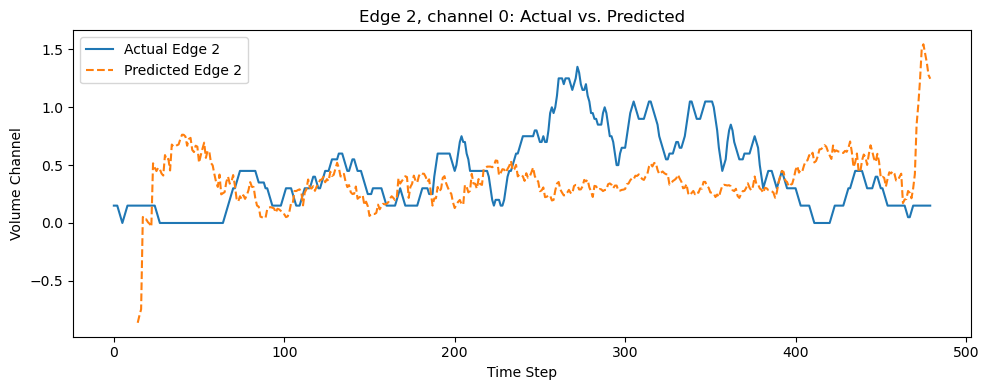

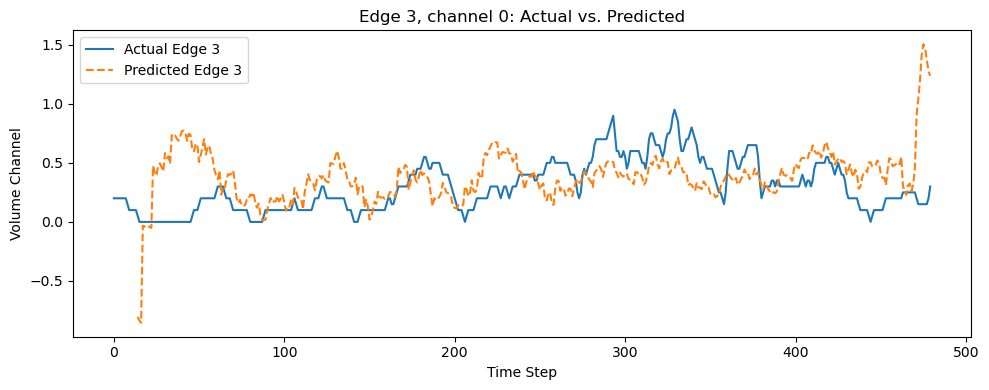

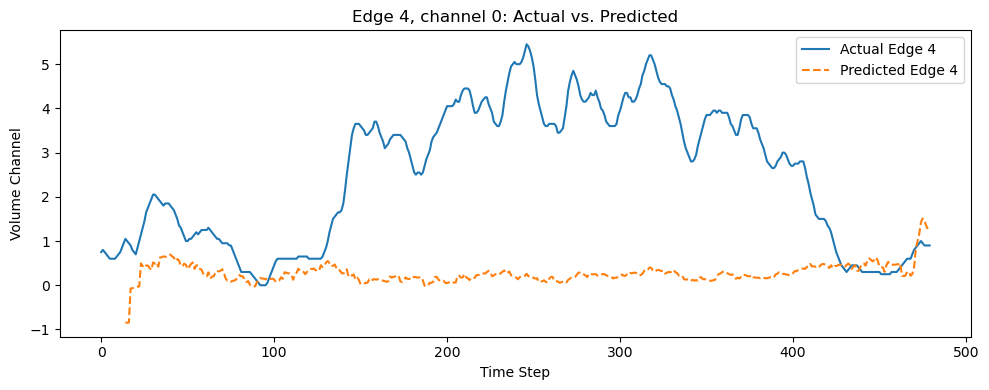

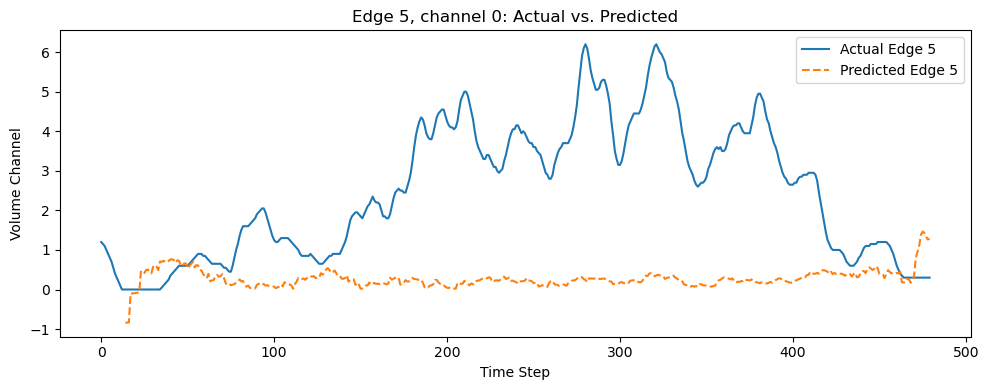

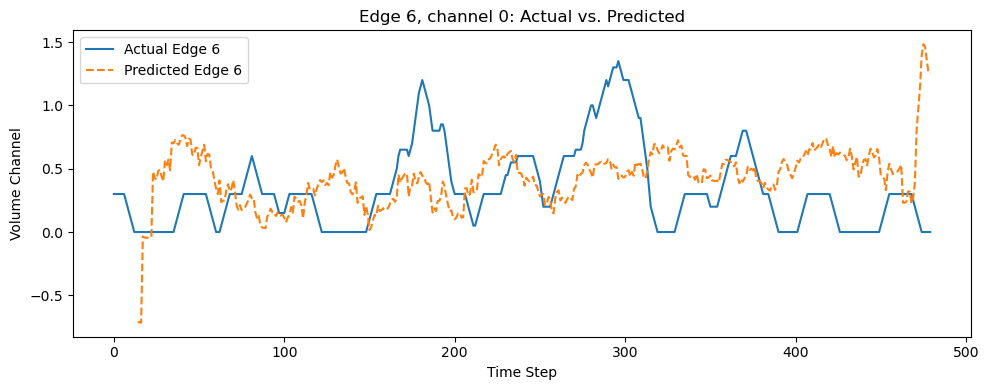

In [ ]:
model.to(DEVICE)
print(f"\n--- Visualizing {name} ---")
EDGE_IDS = [0,1,2,3,4,5,6]
expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=0)

In [ ]:
calculate_performance_index(model, valid_loader, criterion, DEVICE, EDGE_INDEX, EDGE_ATTR)

Evaluating: 100%|██████████| 53/53 [00:03<00:00, 15.97it/s]

Dataset size: 3337 samples
Average Loss (L2/MSE): 3.1268
Average MAPE:         4.2616
Average MAE:          3.1268
Average RMSE:         7.6365


In [ ]:
print(min(trainer.get_history()['valid_loss']))
print(min(trainer.get_history()['valid_mape']))

0.6131503844925627
0.3864663140052873
